* `Import Libraries`

In [58]:
import numpy as np
import pandas as pd
import re
import os
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from imblearn.over_sampling import SMOTE
import nltk
import spacy
from tqdm import tqdm
from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize
from nltk.corpus import stopwords
from gensim.models.word2vec import Word2Vec
import gensim.downloader as api
nltk.download('punkt')
nltk.download('wordnet')

# Load spaCy's GloVe medium model
nlp = spacy.load("en_core_web_md")

[nltk_data] Downloading package punkt to C:\Users\moham/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\moham/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [59]:
## Readind using pandas
df = pd.read_csv('testdata.manual.2009.06.14.csv', 
                encoding='ISO-8859-1', names=['target', 'id', 'date', 'flags', 'user', 'text'])
df.head()

,target,id,date,flags,user,text
0,4,3,Mon May 11 03:17:40 UTC 2009,kindle2,tpryan,@stellargirl I loooooooovvvvvveee my Kindle2. ...
1,4,4,Mon May 11 03:18:03 UTC 2009,kindle2,vcu451,Reading my kindle2... Love it... Lee childs i...
2,4,5,Mon May 11 03:18:54 UTC 2009,kindle2,chadfu,"Ok, first assesment of the #kindle2 ...it fuck..."
3,4,6,Mon May 11 03:19:04 UTC 2009,kindle2,SIX15,@kenburbary You'll love your Kindle2. I've had...
4,4,7,Mon May 11 03:21:41 UTC 2009,kindle2,yamarama,@mikefish Fair enough. But i have the Kindle2...


* `EDA`

In [60]:
print('The Shape of the Dataset is: ', df.shape)

The Shape of the Dataset is:  (498, 6)


In [61]:
## Check the info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 498 entries, 0 to 497
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   target  498 non-null    int64 
 1   id      498 non-null    int64 
 2   date    498 non-null    object
 3   flags   498 non-null    object
 4   user    498 non-null    object
 5   text    498 non-null    object
dtypes: int64(2), object(4)
memory usage: 23.5+ KB


In [62]:
df.dtypes

target     int64
id         int64
date      object
flags     object
user      object
text      object
dtype: object

In [63]:
df['target'].value_counts()  # 0: Negative, 2: Neutral, 4: Positive

target
4    182
0    177
2    139
Name: count, dtype: int64

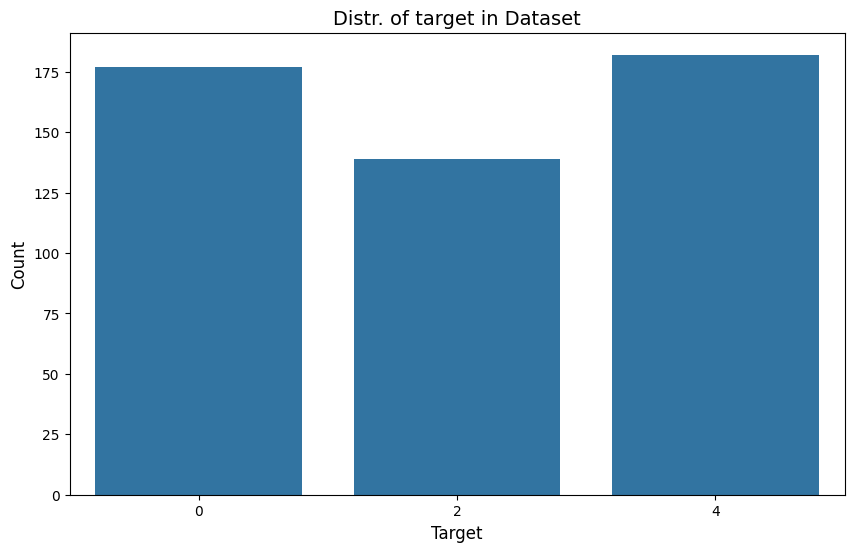

In [64]:
## countplot of target
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='target')
plt.title('Distr. of target in Dataset', fontsize=14, c='k')
plt.xlabel('Target', c='k', fontsize=12)
plt.ylabel('Count', c='k', fontsize=12)
plt.show()

In [ ]:
# take a deep copy from the DF
dataset = df[['target', 'text']]
dataset

,target,text
0,4,@stellargirl I loooooooovvvvvveee my Kindle2. ...
1,4,Reading my kindle2... Love it... Lee childs i...
2,4,"Ok, first assesment of the #kindle2 ...it fuck..."
3,4,@kenburbary You'll love your Kindle2. I've had...
4,4,@mikefish Fair enough. But i have the Kindle2...
...,...,...
493,2,Ask Programming: LaTeX or InDesign?: submitted...
494,0,"On that note, I hate Word. I hate Pages. I hat..."
495,4,Ahhh... back in a *real* text editing environm...
496,0,"Trouble in Iran, I see. Hmm. Iran. Iran so far..."


----

* `Text Cleaning & Viz`

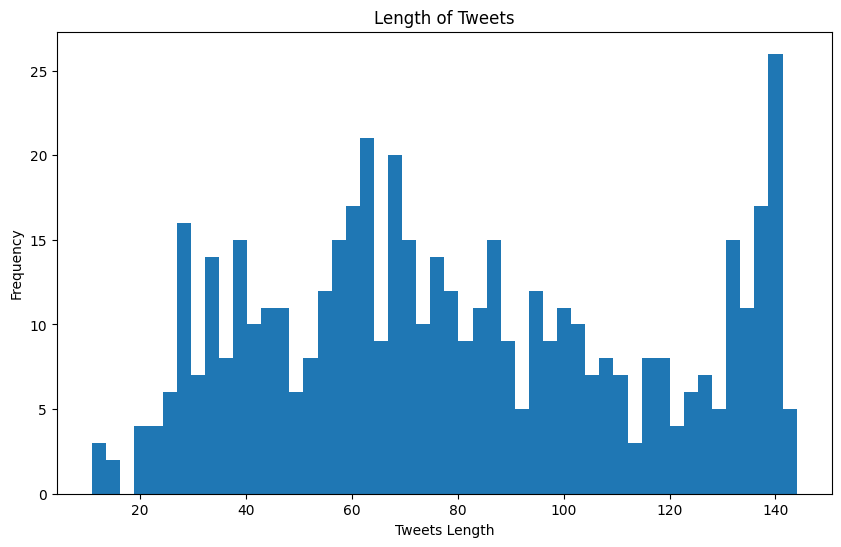

In [66]:
length_tweets = dataset['text'].str.len()
# Plotting
plt.figure(figsize=(10, 6))
plt.hist(length_tweets, bins=50)
plt.title('Length of Tweets')
plt.xlabel('Tweets Length')
plt.ylabel('Frequency')
plt.show()

In [67]:
# Hashtags
def hashtag_extract(x):
    hashtags = []
    ## Loop over the words in the tweet
    for i in x:
        ht = re.findall(r"#(\w+)", i)
        hashtags.append(ht)

    return hashtags


# Extracting hashtags for each class
hash_neg = hashtag_extract(dataset[dataset['target']==0]['text'])  # Negative Hashtags
hash_neu = hashtag_extract(dataset[dataset['target']==2]['text'])  # Neutral Hashtags
hash_pos = hashtag_extract(dataset[dataset['target']==4]['text'])  # Positive Hashtags

# Unnesting the lists
hash_neg = sum(hash_neg, [])
hash_pos = sum(hash_pos, [])
hash_neu = sum(hash_neu, [])

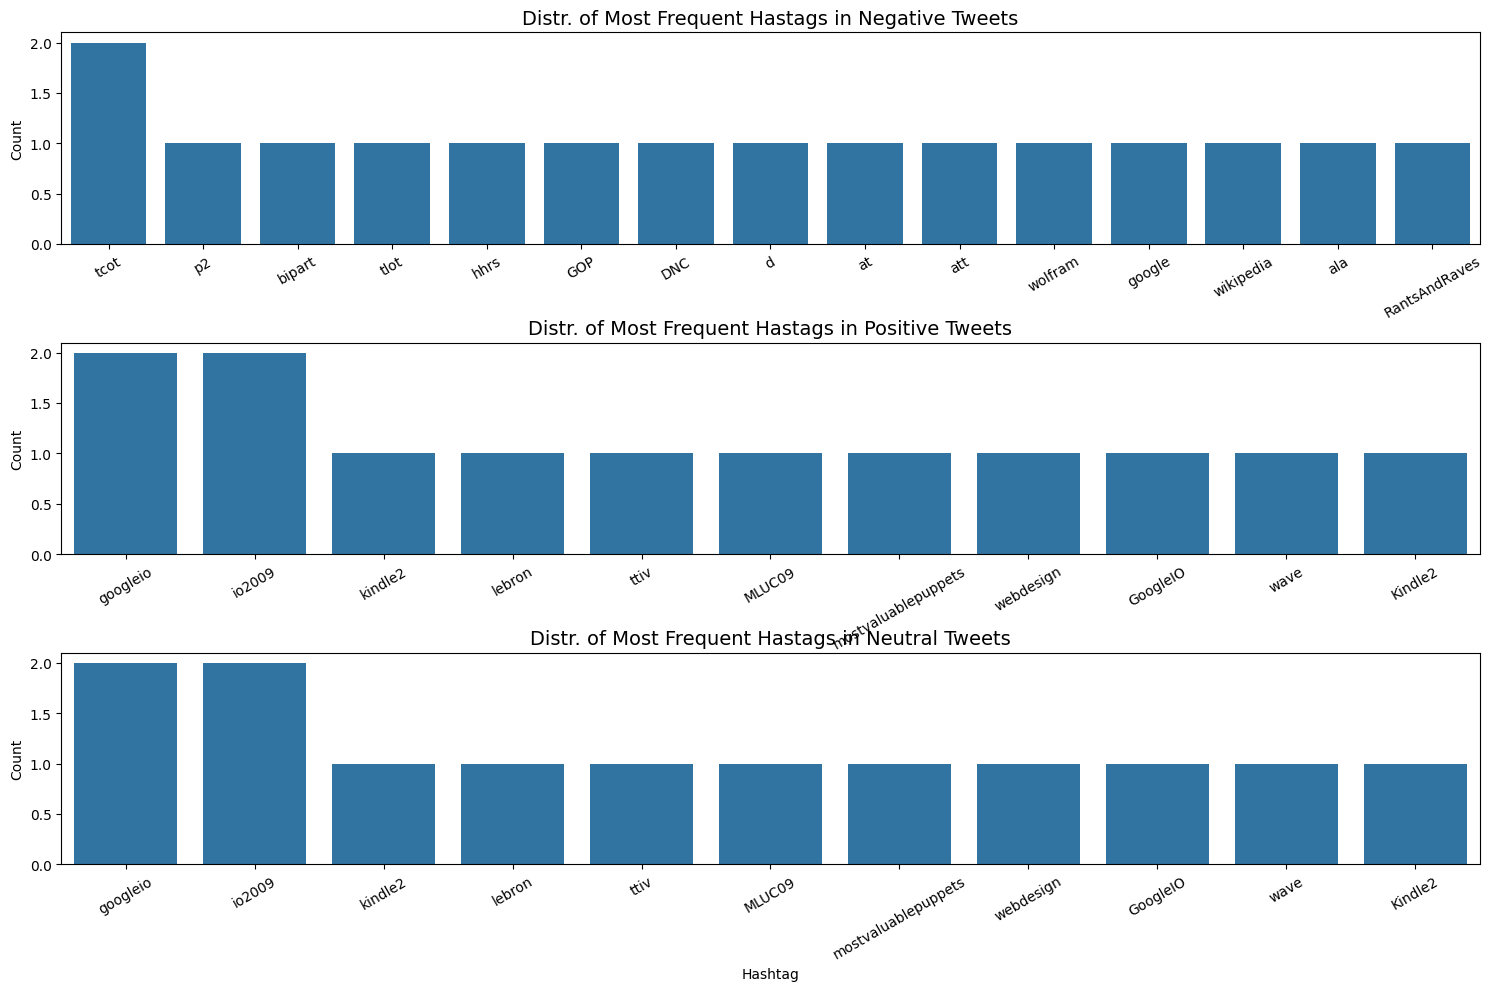

In [68]:
a_neg = nltk.FreqDist(hash_neg)
a_neu = nltk.FreqDist(hash_neu)
a_pos = nltk.FreqDist(hash_pos)

# Negative Tweets
df_neg = pd.DataFrame({'Hashtag': list(a_neg.keys()),
                'Count': list(a_neg.values())})

# Positive Tweets
df_pos = pd.DataFrame({'Hashtag': list(a_pos.keys()),
                'Count': list(a_pos.values())})

# Neutral Tweets
df_neu = pd.DataFrame({'Hashtag': list(a_neu.keys()),
                'Count': list(a_neu.values())})

# selecting top 15 most frequent hashtags     
df_neg = df_neg.nlargest(columns='Count', n=15) 
df_pos = df_pos.nlargest(columns='Count', n=15) 
df_neu = df_pos.nlargest(columns='Count', n=15)


# Plotting
fig, ax = plt.subplots(3, 1, figsize=(16, 10))
fig.tight_layout(pad=5)
plt.sca(ax[0])
sns.barplot(data=df_neg, x='Hashtag', y='Count')
plt.xticks(rotation=30)
plt.title('Distr. of Most Frequent Hastags in Negative Tweets', fontsize=14, c='k')
plt.xlabel('')

plt.sca(ax[1])
sns.barplot(data=df_pos, x='Hashtag', y='Count')
plt.xticks(rotation=30)
plt.title('Distr. of Most Frequent Hastags in Positive Tweets', fontsize=14, c='k')
plt.xlabel('')

plt.sca(ax[2])
sns.barplot(data=df_neu, x='Hashtag', y='Count')
plt.xticks(rotation=30)
plt.title('Distr. of Most Frequent Hastags in Neutral Tweets', fontsize=14, c='k')
plt.show()

In [69]:
# Remove unwanted text patterns from the tweets
def remove_pattern(input_txt: str, pattern: str):
    ''' This Function takes the input and pattern you want to remove

    Args:
    *****
        (input_text: str) --> The text you want to apply the function to it.
        (pattern: str) --> The pattern you want to remove from the text.
    '''

    input_txt = re.sub(pattern, '', input_txt)
    return input_txt

* `Remove Tags`

In [70]:
# Removing @user in tweets, and apply the function
dataset.loc[:, 'text'] = dataset['text'].apply(lambda x: remove_pattern(x, r'@[\w]*'))
dataset.head()

,target,text
0,4,I loooooooovvvvvveee my Kindle2. Not that the...
1,4,Reading my kindle2... Love it... Lee childs i...
2,4,"Ok, first assesment of the #kindle2 ...it fuck..."
3,4,You'll love your Kindle2. I've had mine for a...
4,4,Fair enough. But i have the Kindle2 and I th...


* `Remove Hyperlinks`

In [71]:
# An exmaple before removing links
dataset['text'].iloc[493]

'Ask Programming: LaTeX or InDesign?: submitted by calcio1 [link] [1 comment] http://tinyurl.com/myfmf7'

In [72]:
# Define a regular expression pattern to match URLs
# Apply the above function
dataset.loc[:, 'text'] = dataset['text'].apply(lambda x: remove_pattern(x, r'https?://\S+|www\.\S+'))
dataset.head()

,target,text
0,4,I loooooooovvvvvveee my Kindle2. Not that the...
1,4,Reading my kindle2... Love it... Lee childs i...
2,4,"Ok, first assesment of the #kindle2 ...it fuck..."
3,4,You'll love your Kindle2. I've had mine for a...
4,4,Fair enough. But i have the Kindle2 and I th...


In [73]:
# An exmaple before removing links
dataset['text'].iloc[493]

'Ask Programming: LaTeX or InDesign?: submitted by calcio1 [link] [1 comment] '

#### `Remove Repeated Characters`
* It is very challenging, There is no unique solution for this problem.
* We can remove repeated chars from words but it will affect other correct words like (happy be hapy)
* So, We can solve it bydefining a max repeat, Let's make it 2
* Note: It may produces some a few errors (But there is no better solution for that)
* These errors may be solved in stemmer or lemmatizer later

In [74]:
# An exmaple before removing repeated chars
dataset['text'].iloc[0]

' I loooooooovvvvvveee my Kindle2. Not that the DX is cool, but the 2 is fantastic in its own right.'

In [75]:
# A Function to remove excessive repeated chars while preserving correct words
def remove_excessive_repeated_characters(input_string, max_repeats=2):
    # Define a regular expression pattern to match consecutive repeated characters
    pattern = f"(\\w)\\1{{{max_repeats},}}"
    # Replace the matched pattern with a single occurrence of the character
    cleaned_string = re.sub(pattern, r"\1", input_string)
    
    return cleaned_string

# Apply the above function
dataset.loc[:, 'text'] = dataset['text'].apply(remove_excessive_repeated_characters)
dataset.head()

,target,text
0,4,"I love my Kindle2. Not that the DX is cool, b..."
1,4,Reading my kindle2... Love it... Lee childs i...
2,4,"Ok, first assesment of the #kindle2 ...it fuck..."
3,4,You'll love your Kindle2. I've had mine for a...
4,4,Fair enough. But i have the Kindle2 and I th...


In [76]:
# An exmaple before removing repeated chars
dataset['text'].iloc[0]

' I love my Kindle2. Not that the DX is cool, but the 2 is fantastic in its own right.'

* `Emotions Mapping`

In [77]:
# Check on sample before mapping emoticons
dataset['text'].iloc[73]

'Back when I worked for Nike we had one fav word : JUST DO IT! :)'

In [78]:
# Convert Emojis to Text : example 😀 to Happy , 😢 Sad
# This Dataset doesn't contains emojis, but it contains emotioncons like that :D, :)
# So, We can't demojize, but we will map the moticons to its meaning.

emoticon_meanings = {
    ":)": "Happy",
    ":(": "Sad",
    ":D": "Very Happy",
    ":|": "Neutral",
    ":O": "Surprised",
    "<3": "Love",
    ";)": "Wink",
    ":P": "Playful",
    ":/": "Confused",
    ":*": "Kiss",
    ":')": "Touched",
    "XD": "Laughing",
    ":3": "Cute",
    ">:(": "Angry",
    ":-O": "Shocked",
    ":|]": "Robot",
    ":>": "Sly",
    "^_^": "Happy",
    "O_o": "Confused",
    ":-|": "Straight Face",
    ":X": "Silent",
    "B-)": "Cool",
    "<(‘.'<)": "Dance",
    "(-_-)": "Bored",
    "(>_<)": "Upset",
    "(¬‿¬)": "Sarcastic",
    "(o_o)": "Surprised",
    "(o.O)": "Shocked",
    ":0": "Shocked",
    ":*(": "Crying",
    ":v": "Pac-Man",
    "(^_^)v": "Double Victory",
    ":-D": "Big Grin",
    ":-*": "Blowing a Kiss",
    ":^)": "Nosey",
    ":-((": "Very Sad",
    ":-(": "Frowning",
}


# Function to replace emoticons with their meanings
def convert_emoticons(text: str):
    ''' This Function is to replace the emoticons with thier meaning instead 
    '''
    for emoticon, meaning in emoticon_meanings.items():
        text = text.replace(emoticon, meaning)
    return text

# Apply the function on our dataset
dataset.loc[:, 'text'] = dataset['text'].apply(convert_emoticons)
dataset.head()

,target,text
0,4,"I love my Kindle2. Not that the DX is cool, b..."
1,4,Reading my kindle2... Love it... Lee childs i...
2,4,"Ok, first assesment of the #kindle2 ...it fuck..."
3,4,You'll love your Kindle2. I've had mine for a...
4,4,Fair enough. But i have the Kindle2 and I th...


In [79]:
# Check on sample before mapping emoticons
dataset['text'].iloc[73]

'Back when I worked for Nike we had one fav word : JUST DO IT! Happy'

* `Remove Punctuatiosn, Numbers, Special Chars`

In [80]:
# Removing Punctuations, Numbers, and Special Characters
dataset.loc[:, 'text'] = dataset['text'].str.replace('[^a-zA-Z#]', ' ', regex=True)
dataset.head()

,target,text
0,4,I love my Kindle Not that the DX is cool b...
1,4,Reading my kindle Love it Lee childs i...
2,4,Ok first assesment of the #kindle it fuck...
3,4,You ll love your Kindle I ve had mine for a...
4,4,Fair enough But i have the Kindle and I th...


* `Removing short words`

In [81]:
# Removing Short Words
dataset.loc[:, 'text'] = dataset['text'].apply(lambda x: ' '.join([w for w in x.split() if len(w) > 3]))
dataset.head()

,target,text
0,4,love Kindle that cool fantastic right
1,4,Reading kindle Love childs good read
2,4,first assesment #kindle fucking rocks
3,4,love your Kindle mine months never looked back...
4,4,Fair enough have Kindle think perfect Happy


* `Remove Numbers from Words`

In [82]:
# Call the above function (remove_pattern), We want to remove the numbers from words 
# We don't remove all numbers on the dataset, The pattern only removes the numbers within the words
dataset.loc[:, 'text'] = dataset['text'].apply(lambda x: remove_pattern(x, '(?<=\w)\d+|\d+(?=\w)'))
dataset.head()

,target,text
0,4,love Kindle that cool fantastic right
1,4,Reading kindle Love childs good read
2,4,first assesment #kindle fucking rocks
3,4,love your Kindle mine months never looked back...
4,4,Fair enough have Kindle think perfect Happy


* `Remove Special Chars`

In [83]:
# An exmaple before removing special chars
dataset['text'].iloc[2]

'first assesment #kindle fucking rocks'

In [84]:
# Define a regular expression pattern to match special characters
# Apply the function to the dataset
dataset.loc[:, 'text'] = dataset['text'].apply(lambda x: remove_pattern(x, r'[!@#$%^&*()_+{}\[\]:;<>,.?~\\|\/]'))
dataset.head()

,target,text
0,4,love Kindle that cool fantastic right
1,4,Reading kindle Love childs good read
2,4,first assesment kindle fucking rocks
3,4,love your Kindle mine months never looked back...
4,4,Fair enough have Kindle think perfect Happy


In [85]:
# An exmaple before removing special chars
dataset['text'].iloc[2]

'first assesment kindle fucking rocks'

* `Rmeove Redundant words`

In [86]:
# An exmaple before solving that
dataset['text'].iloc[3]

'love your Kindle mine months never looked back huge need remorse Happy'

In [87]:
# A Function to remove redundant words like (I've, You'll)
# Again, It is challenging

def remove_redundant_words_extra_spaces(text: str):
    # Remove contractions using regular expressions
    contraction_pattern = re.compile(r"'\w+|\w+'\w+|\w+'")
    text = contraction_pattern.sub('', text)

    # Define a set of stopwords
    stop_words = set(stopwords.words("english"))

    # Remove stopwords and extra spaces
    words = text.split()
    filtered_words = [word for word in words if word.lower() not in stop_words]
    clean_text = ' '.join(filtered_words)

    # Remove extra spaces
    clean_text = ' '.join(clean_text.split())
    
    return clean_text


# Apply the above function
dataset.loc[:, 'text'] = dataset['text'].apply(remove_redundant_words_extra_spaces)
dataset.head()

,target,text
0,4,love Kindle cool fantastic right
1,4,Reading kindle Love childs good read
2,4,first assesment kindle fucking rocks
3,4,love Kindle mine months never looked back huge...
4,4,Fair enough Kindle think perfect Happy


In [88]:
# An exmaple before solving that
dataset['text'].iloc[3]

'love Kindle mine months never looked back huge need remorse Happy'

In [89]:
# Create a folder for cleaned dataset
CLEANED_DATASET = os.path.join(os.getcwd(), "cleaned-dataset")
os.makedirs(CLEANED_DATASET, exist_ok=True)

In [90]:
# Download the dataset here at this step before Lemmatizing
dataset.to_csv(os.path.join(CLEANED_DATASET, "cleaned_dataset_1.csv"), index=False)

* `Tokenization`

In [91]:
# Apply word_tokenize
tokenized_tweet = dataset['text'].apply(lambda x: word_tokenize(x))
tokenized_tweet.head()

0               [love, Kindle, cool, fantastic, right]
1          [Reading, kindle, Love, childs, good, read]
2           [first, assesment, kindle, fucking, rocks]
3    [love, Kindle, mine, months, never, looked, ba...
4        [Fair, enough, Kindle, think, perfect, Happy]
Name: text, dtype: object

In [92]:
# Lemmatizer
lemmatizer = WordNetLemmatizer()

# Apply Lemmatization
tokenized_tweet = tokenized_tweet.apply(lambda x: [lemmatizer.lemmatize(i) for i in x])

# Join words
dataset.loc[:, 'text'] = tokenized_tweet.apply(lambda x: ' '.join(x))

dataset.head()

,target,text
0,4,love Kindle cool fantastic right
1,4,Reading kindle Love child good read
2,4,first assesment kindle fucking rock
3,4,love Kindle mine month never looked back huge ...
4,4,Fair enough Kindle think perfect Happy


In [93]:
# Download after Lemmatizing
dataset.to_csv(os.path.join(CLEANED_DATASET, "cleaned_dataset_2.csv"), index=False)

----

* `Some Viz`

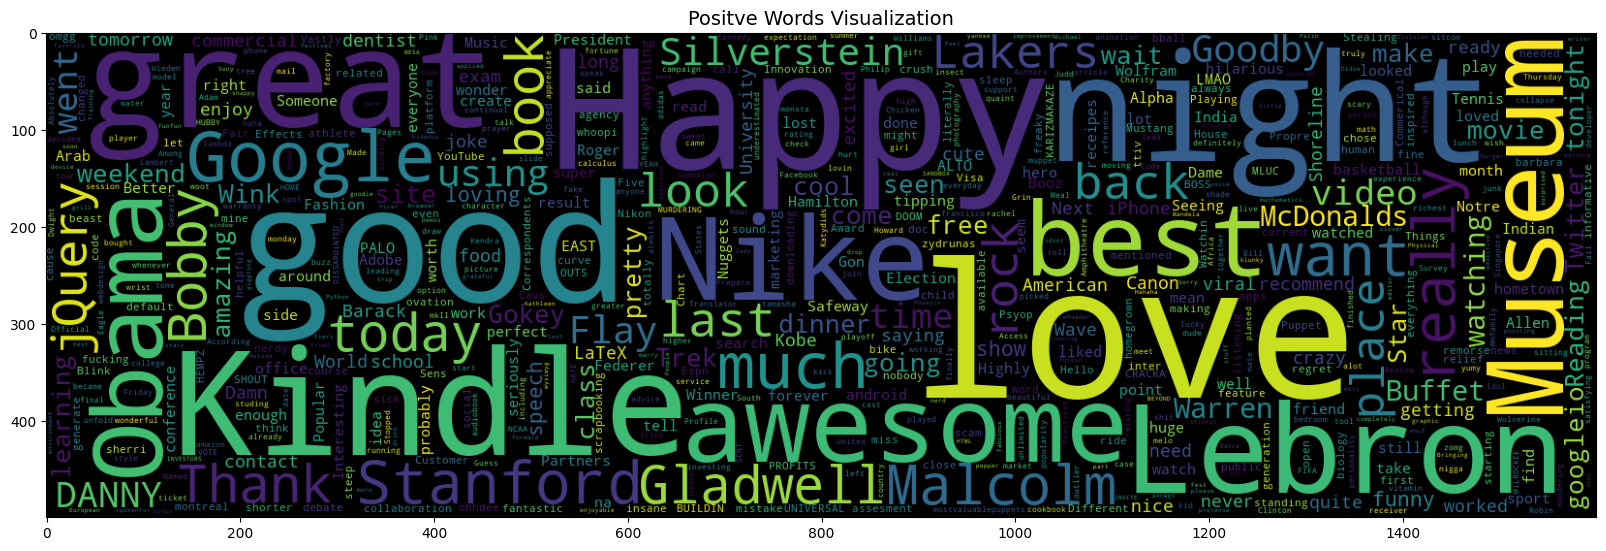

In [94]:
## For Positive Words
plt.figure(figsize=(20, 8))
wc = WordCloud(max_words=10000, width=1600, height=500, 
            collocations=False).generate(" ".join(dataset[dataset['target']==4]['text'].astype(str)))
plt.title('Positve Words Visualization', fontsize=14, c='k')
plt.imshow(wc)
plt.show()

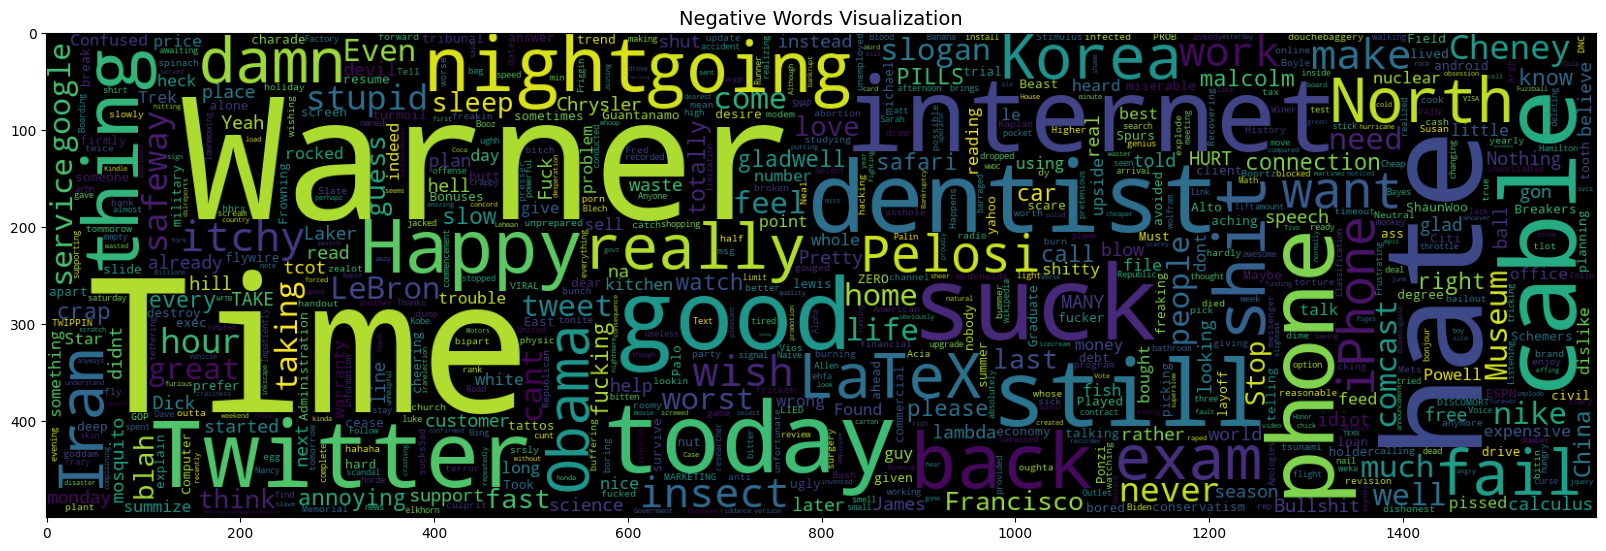

In [95]:
## For Negative Words
plt.figure(figsize=(20, 8))
wc = WordCloud(max_words=10000, width=1600, height=500, 
            collocations=False).generate(" ".join(dataset[dataset['target']==0]['text'].astype(str)))
plt.title('Negative Words Visualization', fontsize=14, c='k')
plt.imshow(wc)
plt.show()

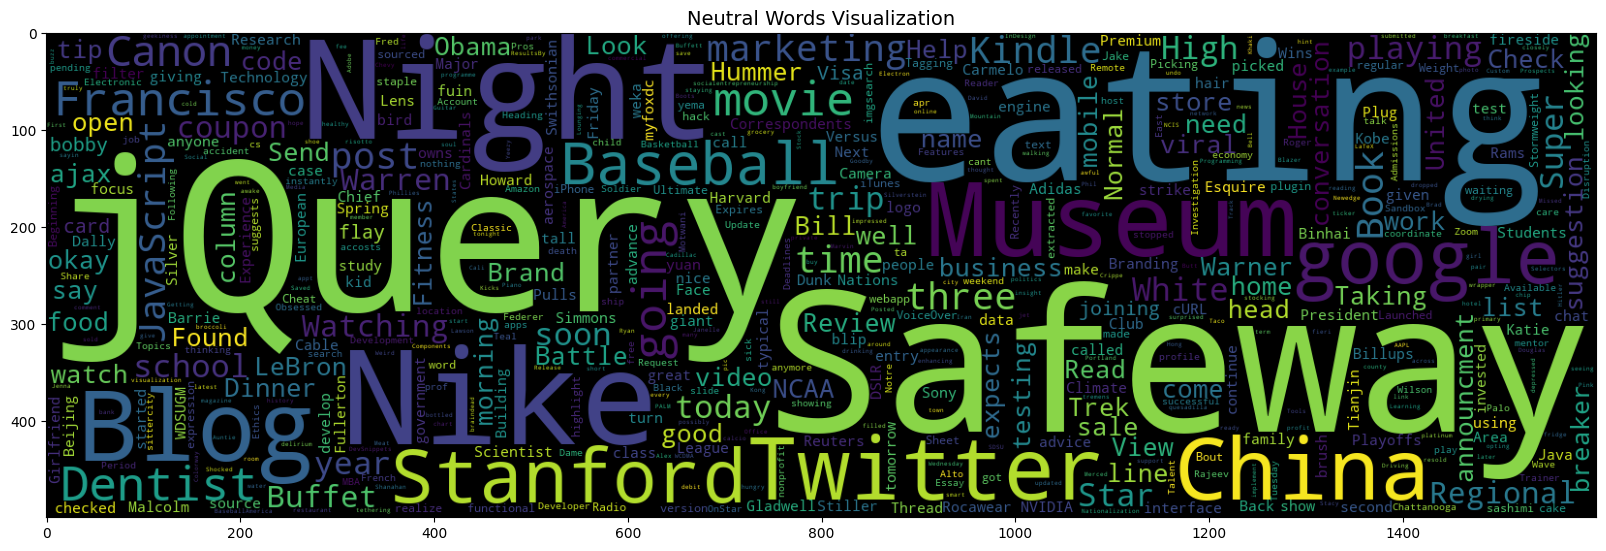

In [96]:
## For Neutral Words
plt.figure(figsize=(20, 8))
wc = WordCloud(max_words=10000, width=1600, height=500, 
            collocations=False).generate(" ".join(dataset[dataset['target']==2]['text'].astype(str)))
plt.title('Neutral Words Visualization', fontsize=14, c='k')
plt.imshow(wc)
plt.show()

* `Vectorization`

* `1. BOW`

In [97]:
# Extracting Features from Cleaned Tweets using BOW 
bow_vectorizer = CountVectorizer(max_df=0.90, min_df=2, max_features=None, stop_words='english')
X_bow = bow_vectorizer.fit_transform(dataset['text'])
X_bow = X_bow.toarray()
X_bow

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [98]:
# artifacts folder path
ARTIFACTS_FOLDER_PATH = os.path.join(os.getcwd(), '..', 'artifacts')
os.makedirs(ARTIFACTS_FOLDER_PATH, exist_ok=True)

In [99]:
# dump the bow_vectorizer
joblib.dump(bow_vectorizer, os.path.join(ARTIFACTS_FOLDER_PATH, 'bow_vectorizer.pkl'))

['c:\\Users\\moham\\Desktop\\RNN, Embeddings Projects\\sentiment-anslysis end to end\\src\\notebooks\\..\\artifacts\\bow_vectorizer.pkl']

`2. TF-IDF`

In [100]:
# Extracting Features from Cleaned Tweets using TF-IDF
tfidf_vectorizer = TfidfVectorizer(max_df=0.90, min_df=2, max_features=None, stop_words='english')
X_tfidf = tfidf_vectorizer.fit_transform(dataset['text'])
X_tfidf = X_tfidf.toarray()
X_tfidf

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [101]:
joblib.dump(tfidf_vectorizer, os.path.join(ARTIFACTS_FOLDER_PATH, 'tfidf_vectorizer.pkl'))

['c:\\Users\\moham\\Desktop\\RNN, Embeddings Projects\\sentiment-anslysis end to end\\src\\notebooks\\..\\artifacts\\tfidf_vectorizer.pkl']

`3. GloVe`

In [102]:
# Using GloVe
X_glove = np.array([nlp(text).vector for text in tqdm(dataset["text"])])
X_glove

100%|██████████| 498/498 [00:07<00:00, 70.54it/s]


array([[-0.672672  ,  0.1643478 , -0.16596639, ...,  0.05450799,
         0.0097094 ,  0.1456826 ],
       [-0.6808767 ,  0.29182148, -0.20641865, ..., -0.16637833,
         0.01048784,  0.3305572 ],
       [-0.766266  , -0.09361979, -0.1116804 , ...,  0.0479892 ,
        -0.0781142 , -0.0077544 ],
       ...,
       [-0.69465667, -0.04289534, -0.20735167, ..., -0.09098934,
        -0.035964  , -0.19876902],
       [-0.577745  ,  0.003495  ,  0.04872834, ...,  0.05882917,
        -0.2888053 ,  0.32526886],
       [-0.70540506,  0.11329388, -0.14466599, ..., -0.13584839,
        -0.09285676,  0.1615859 ]], dtype=float32)

`4. FastText`

In [103]:
# Tokenize text data
tokenized_sentences = [text.split() for text in dataset["text"]]

# You can use pretrained models ready for Word2Vec and FastText, and more, But I will train it (it is samll corpus may be not good option)
w2vec_model = Word2Vec(
    sentences=tokenized_sentences, 
    vector_size=300,
    window=5,
    min_count=1,
    sg=1,
    epochs=20,
    workers=4
)

# Save the trained model
w2vec_model.save(os.path.join(ARTIFACTS_FOLDER_PATH, "w2vec_custom.model"))

In [104]:
def sentence_to_vector(sentence):
    """Convert a sentence into a Word2Vec vector by averaging word vectors."""
    words = sentence.split()
    word_vectors = [w2vec_model.wv[word] for word in words if word in w2vec_model.wv]
    
    if len(word_vectors) == 0:
        return np.zeros(300)

    return np.mean(word_vectors, axis=0)

# Convert all tweets
X_w2vec_custom = np.array([
    sentence_to_vector(text) for text in dataset["text"]
])
X_w2vec_custom

array([[-0.00421202,  0.02208007,  0.01068351, ..., -0.01852917,
         0.01937182,  0.00401483],
       [-0.00359366,  0.02192298,  0.0105875 , ..., -0.01715097,
         0.01702999,  0.00210982],
       [-0.0022349 ,  0.01257649,  0.00376644, ..., -0.00836313,
         0.01036891,  0.00114332],
       ...,
       [-0.00461491,  0.0204936 ,  0.00956497, ..., -0.01755497,
         0.01620259,  0.00240613],
       [-0.00103337,  0.02474842,  0.00976027, ..., -0.01743881,
         0.01812684,  0.00346034],
       [-0.00179959,  0.01697357,  0.0065557 , ..., -0.01364186,
         0.01171536,  0.00289417]], dtype=float32)

`5. GloVe Twitter`

In [105]:
# Load pre-trained model
glove_twitter_model = api.load("glove-twitter-25")

In [106]:
def sentence_to_vector_pretrained(sentence):
    words = sentence.lower().split()
    word_vectors = [glove_twitter_model[word] for word in words if word in glove_twitter_model]
    
    if len(word_vectors) == 0:
        return np.zeros(25)  # GloVe Twitter has 25 dimensions

    return np.mean(word_vectors, axis=0)

# Convert all tweets to vectors
X_glove_twitter = np.array([
    sentence_to_vector_pretrained(text) for text in dataset["text"]
])
X_glove_twitter.shape

(498, 25)

---

* `Split The dataset`

In [107]:
# mapping --> Some Algoritms can't handle non sequential encoding
dict_map = {0: 0, 4: 1, 2: 2}    # 0: Negative (still 0) || 4: Positive > 1 || 2: Neutral (still 2)
dict_rev_map = {v: k for k, v in dict_map.items()}

# Apply that to the dataset
dataset.loc[:, 'target'] = dataset['target'].map(dict_map)
dataset['target'].head()

0    1
1    1
2    1
3    1
4    1
Name: target, dtype: int64

In [108]:
# Function to be easy in training the model
def prepare_data(method='BOW'):
    if method.lower() == 'bow':
        X = X_bow
    elif method.lower() == 'tfidf':
        X = X_tfidf 
    elif method.lower() == 'word2vec':
        X = X_w2vec_custom
    elif method.lower() == 'glove':
        X = X_glove
    elif method.lower() == 'glove_twitter':
        X = X_glove_twitter
    else:
        raise ValueError("Enter a valid method from ('BOW', 'TFIDF', 'Word2Vec', 'GloVe', 'GloVe_Twitter')")
    
    y = dataset['target']
    
    # Using SMOTE to solve imblanced dataset
    over = SMOTE()
    X_new, y_new = over.fit_resample(X, y)

    # Split Datsets to train and test
    X_train, X_test, y_train, y_test = train_test_split(X_new, y_new, 
                                                        shuffle=True, stratify=y_new, 
                                                        test_size=0.2, random_state=15)
    
    return X_train, X_test, y_train, y_test

* `Building Models`

* `SVM`

In [109]:
def svm_model(method: str): 

    X_train, X_test, y_train, y_test = prepare_data(method=method)
    
    svc = SVC(C=0.98, kernel='rbf', gamma=0.15, random_state=42)
    svc.fit(X_train, y_train)
    
    # Accuracy
    y_pred_train_svc = svc.predict(X_train)
    y_pred_test_svc = svc.predict(X_test)
    
    acc_train_svc = round(100*accuracy_score(y_train, y_pred_train_svc), 4)
    acc_test_svc = round(100*accuracy_score(y_test, y_pred_test_svc), 4)
    
    return svc, acc_train_svc, acc_test_svc

In [110]:
# BOW with SVM
svc_bow, acc_train_svm_bow, acc_test_svm_bow = svm_model(method='BOW')
print(f'Accuracy Score for Training Dataset using BOW using SVM:\t {acc_train_svm_bow} %')
print(f'Accuracy Score for Testing Dataset using BOW using SVM: \t {acc_test_svm_bow} %')

Accuracy Score for Training Dataset using BOW using SVM:	 86.6972 %
Accuracy Score for Testing Dataset using BOW using SVM: 	 73.6364 %


In [111]:
# Using TFIDF with SVM
svc_tfidf, acc_train_svm_tfidf, acc_test_svm_tfidf = svm_model(method='TFIDF')
print(f'Accuracy Score for Training Dataset using TFIDF using SVM:\t {acc_train_svm_tfidf} %')
print(f'Accuracy Score for Testing Dataset using TFIDF using SVM:\t {acc_test_svm_tfidf} %')

Accuracy Score for Training Dataset using TFIDF using SVM:	 81.1927 %
Accuracy Score for Testing Dataset using TFIDF using SVM:	 72.7273 %


In [112]:
# Using Glove with SVM
svc_glove, acc_train_svm_glove, acc_test_svm_glove = svm_model(method='glove')
print(f'Accuracy Score for Training Dataset using GloVe using SVM:\t {acc_train_svm_glove} %')
print(f'Accuracy Score for Testing Dataset using GloVe using SVM:\t {acc_test_svm_glove} %')

Accuracy Score for Training Dataset using GloVe using SVM:	 93.1193 %
Accuracy Score for Testing Dataset using GloVe using SVM:	 67.2727 %


In [113]:
# Using Glove with SVM
svc_glove, acc_train_svm_w2vec, acc_test_svm_w2vec = svm_model(method='word2vec')
print(f'Accuracy Score for Training Dataset using Word2vec using SVM:\t {acc_train_svm_w2vec} %')
print(f'Accuracy Score for Testing Dataset using Word2vec using SVM:\t {acc_test_svm_w2vec} %')

Accuracy Score for Training Dataset using Word2vec using SVM:	 33.945 %
Accuracy Score for Testing Dataset using Word2vec using SVM:	 33.6364 %


In [114]:
# Using Glove with SVM
svc_glove, acc_train_svm_glove_twitter, acc_test_svm_glove_twitter = svm_model(method='glove_twitter')
print(f'Accuracy Score for Training Dataset using GloVeTwitter using SVM:\t {acc_train_svm_glove_twitter} %')
print(f'Accuracy Score for Testing Dataset using GloVeTwitter using SVM:\t {acc_test_svm_glove_twitter} %')

Accuracy Score for Training Dataset using GloVeTwitter using SVM:	 81.1927 %
Accuracy Score for Testing Dataset using GloVeTwitter using SVM:	 72.7273 %


In [115]:
# Combine all results of SVM wihtout Jaya in one DataFrame
acc_train_svm = [acc_train_svm_bow, acc_train_svm_tfidf, 
                acc_train_svm_glove, acc_train_svm_w2vec, acc_train_svm_glove_twitter]
acc_test_svm = [acc_test_svm_bow, acc_test_svm_tfidf, 
                acc_test_svm_glove, acc_test_svm_w2vec, acc_test_svm_glove_twitter]


# Create a DataFrame for SVM accuracies
data_svm = {
        'vect_method': ['BOW', 'TF-IDF', "GloVe", "Word2Vec", "GloVe-Twitter"],
        'train_acc': acc_train_svm,
        'test_acc': acc_test_svm
            }

svm_accuracy_df = pd.DataFrame(data_svm).sort_values(by="test_acc", ascending=False)
svm_accuracy_df

,vect_method,train_acc,test_acc
0,BOW,86.6972,73.6364
1,TF-IDF,81.1927,72.7273
4,GloVe-Twitter,81.1927,72.7273
2,GloVe,93.1193,67.2727
3,Word2Vec,33.9450,33.6364


In [116]:
# dump model
joblib.dump(svc_bow, os.path.join(ARTIFACTS_FOLDER_PATH, 'svm_bow.pkl'))

['c:\\Users\\moham\\Desktop\\RNN, Embeddings Projects\\sentiment-anslysis end to end\\src\\notebooks\\..\\artifacts\\svm_bow.pkl']

----